# BAOAB method in Julia

In [22]:
function A_step(qp, h)
    q, p = qp
    q = q + h * p
    return [q, p]
end

function B_step(qp, h, force)
    q, p = qp
    F = force
    p = p + h * F
    return [q, p]
end

function O_step(qp, h, A, beta)
    q, p = qp
    alpha = exp(-h * A)
    R = randn(length(q))
    p = alpha * p + sqrt(1 / beta) * sqrt(1 - exp(-2 * h * A)) * R
    return [q, p]
end

function BAOAB_step(q, p, h, A, beta, force)
    qp = copy([q, p])
    qp = B_step(qp, h/2, force)
    qp = A_step(qp, h/2)
    qp = O_step(qp, h, A, beta)
    qp = A_step(qp, h/2)
    qp = B_step(qp, h/2, force)
    q, p = qp
    return q, p
end

BAOAB_step (generic function with 1 method)

In [23]:
function grad_gaussian(data, theta, N, n)
    # 1st model - Bayesian Inference for Gaussian Distribution
    mu, gamma = theta

    sigma_x = sum(data)
    sigma_x2 = sum((data .- mu).^2)

    d_mu = (N + 1) * mu * gamma - gamma * N * sigma_x / n 
    d_gamma = 1 - (N + 1) / (2 * gamma) + mu^2 / 2 + N * sigma_x2 / (2 * n)

    return [d_mu, d_gamma]
end

function run_simulation(q0, p0, Nsteps, h, A, beta, Samples, step_function, grad_U, N, n)
    q_traj = zeros(2,Nsteps)
    p_traj = zeros(2,Nsteps)
    t_traj = zeros(Nsteps)

    q = copy(q0)
    p = copy(p0)
    t = 0.0

    for i in 1:Nsteps
        idx = randperm(N)[1:n]
        data = Samples[idx]
        force = - grad_U(data, q, N, n)
        q, p = step_function(q, p, h, A, beta, force)
        t += h
        
        q_traj[:,i] = q
        p_traj[:,i] = p
        t_traj[i] = t
    end

    return q_traj, p_traj, t_traj
end

run_simulation (generic function with 1 method)

In [24]:
function save_variable(variable, file_name)
    name = string(file_name, ".jls")
    open(name, "w") do file
        serialize(file, variable)
    end
end

save_variable (generic function with 1 method)

In [25]:
function bias_pdf(q_traj, mu_dist, gamma_dist)
    if isnan(q_traj[1,end]) || isinf(q_traj[1,end])
        return [Inf, Inf]
    end

    x1 = range(minimum(q_traj[1,:]), maximum(q_traj[1,:]), length=100)
    x2 = range(minimum(q_traj[2,:]), maximum(q_traj[2,:]), length=100)
    
    edge_q1 = collect(x1)
    edge_q2 = collect(x2)

    hist_q1 = fit(Histogram, q_traj[1,:], edge_q1)
    hist_q2 = fit(Histogram, q_traj[2,:], edge_q2)

    bin_centers_q1 = (edge_q1[1:end-1] .+ edge_q1[2:end]) ./ 2
    bin_centers_q2 = (edge_q2[1:end-1] .+ edge_q2[2:end]) ./ 2

    bin_widths_q1 = diff(edge_q1)
    total_counts_q1 = sum(hist_q1.weights)
    hist_density_q1 = hist_q1.weights ./ (total_counts_q1 .* bin_widths_q1)

    bin_widths_q2 = diff(edge_q2)
    total_counts_q2 = sum(hist_q2.weights)
    hist_density_q2 = hist_q2.weights ./ (total_counts_q2 .* bin_widths_q2)

    q1_dist = pdf(mu_dist, bin_centers_q1)
    q2_dist = pdf(gamma_dist, bin_centers_q2)

    errors_q1 = q1_dist - hist_density_q1
    errors_q2 = q2_dist - hist_density_q2

    # Calculate mean square error (MSE) and root mean square error (RMSE)
    mse_q1 = mean(errors_q1.^2)
    rmse_q1 = sqrt(mse_q1)
    mse_q2 = mean(errors_q2.^2)
    rmse_q2 = sqrt(mse_q2)
    return [rmse_q1, rmse_q2]
end

# function bias_para(q_traj, mu_N, alpha_N, beta_N)
#     q2_true = alpha_N/beta_N
#     q1_mean = mean(q_traj[1,:])

bias_pdf (generic function with 1 method)

In [26]:
# x1 = range(minimum(q_traj[1,:]), maximum(q_traj[1,:]), length=100)
# x2 = range(minimum(q_traj[2,:]), maximum(q_traj[2,:]), length=100)

# edge_q1 = collect(x1)
# edge_q2 = collect(x2)

# hist_q1 = fit(Histogram, q_traj[1,:], edge_q1)
# hist_q2 = fit(Histogram, q_traj[2,:], edge_q2)

# bin_centers_q1 = (edge_q1[1:end-1] .+ edge_q1[2:end]) ./ 2
# bin_centers_q2 = (edge_q2[1:end-1] .+ edge_q2[2:end]) ./ 2

# bin_widths_q1 = diff(edge_q1)
# total_counts_q1 = sum(hist_q1.weights)
# hist_density_q1 = hist_q1.weights ./ (total_counts_q1 .* bin_widths_q1)

# bin_widths_q2 = diff(edge_q2)
# total_counts_q2 = sum(hist_q2.weights)
# hist_density_q2 = hist_q2.weights ./ (total_counts_q2 .* bin_widths_q2)

# ex1 = sum(hist_density_q1 .* bin_widths_q1 .* bin_centers_q1)
# ex2 = sum(hist_density_q2 .* bin_widths_q2 .* bin_centers_q2)

# bar(edge_q2, hist_q2.weights / total_counts_q2, xlabel="Bins", ylabel="Frequency", label="Histogram")
# stephist!(p_gamma, q_traj[2,:], bins=800, normalize=:pdf, label="n = $n%", lw=1.5, alpha=0.5)
# vline!([ex2], color="red", linestyle=:dash, label="Expectation")

In [27]:
# Nsteps = 10^6, repeat 6 times for approx 93 min - Bohan
using LaTeXStrings, Random, Plots, Distributions, Serialization, StatsBase, Base.Threads

n_lst = 30:-1:1
A_lst = 10. .^ range(2, -1, length=30)
# A_lst = 101:-4:1
bias_matrix1 = zeros(length(n_lst), length(A_lst))
bias_matrix2 = zeros(length(n_lst), length(A_lst))
repeats = 6

# Initialize one walker
q0 = [0,1]; p0 = randn(2)
Nsteps = 1000000; h = 0.001; beta = 1.0; N = 100
Samples = randn(N)

# calculate the real distribution
x_bar = sum(Samples)/N; 
mu_N = x_bar * N / (N+1); kappa_N = N+1; alpha_N = 1 + N/2; beta_N = 1 + sum((Samples .- x_bar).^2) / 2 + N * x_bar^2 / (2 * (1+N));
v = 2 * alpha_N; std_mu = sqrt(beta_N / (kappa_N*alpha_N)); tdist = TDist(v)
mu_dist = mu_N .+ std_mu .* tdist
gamma_dist = Gamma(alpha_N, 1/beta_N)

lc = ReentrantLock()

# @sync @threads 
for i in 1:length(n_lst)
    n = n_lst[i]
    # @threads 
    for j in 1:length(A_lst)
        bias1, bias2 = zeros(2)
        A = A_lst[j]
        @threads for k in 1:repeats
            q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps, h, A, beta, Samples, BAOAB_step, grad_gaussian, N, n)
            save_variable(q_traj, "10_6,0.001,A$j,$n percent,$k th")
            lock(lc) do
                bias1, bias2 = bias_pdf(q_traj, mu_dist, gamma_dist) .+ [bias1, bias2]
            end
        end
        if isnan(bias1) || isinf(bias1)
            bias_matrix1[i,j] = maximum(bias_matrix1)
            bias_matrix2[i,j] = maximum(bias_matrix2)
        else
            bias_matrix1[i,j], bias_matrix2[i,j] = [bias1, bias2]
        end
    end
end

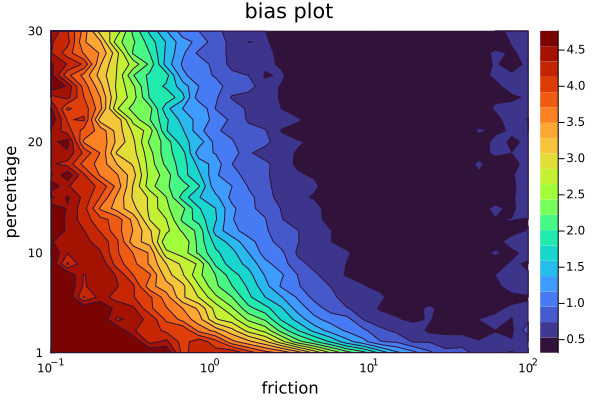

In [28]:
A_ls = reverse(A_lst); n_ls = reverse(n_lst)
bias_matrix1 = zeros(length(n_lst), length(A_lst))
bias_matrix2 = zeros(length(n_lst), length(A_lst))
repeats = 6
for i in 1:length(n_lst)
    n = n_lst[i]
    for j in 1:length(A_lst)
        bias1, bias2 = zeros(2)
        for k in 1:repeats
            q_traj = open(deserialize, "10_6,0.001,A$j,$n percent,$k th.jls")
            bias1, bias2 = bias_pdf(q_traj, mu_dist, gamma_dist) .+ [bias1, bias2]
        end
        if isnan(bias1) || isinf(bias1)
            bias_matrix1[end-i+1,end-j+1] = maximum(bias_matrix1)
            bias_matrix2[end-i+1,end-j+1] = maximum(bias_matrix2)
        else
            bias_matrix1[end-i+1,end-j+1], bias_matrix2[end-i+1,end-j+1] = [bias1, bias2]
        end
    end
end

contour(A_ls, n_ls, bias_matrix1, fill=true)
contourf(A_ls, n_ls, bias_matrix1, levels=20, color=:turbo, colorbar=true)
title!("bias plot")
xaxis!(:log10)
xlabel!("friction")
ylabel!("percentage")
xticks!([0.1, 1, 10, 100])
yticks!([1, 10, 20, 30])